In [11]:
library(Seurat)
library(Signac)
library(magrittr)
library(ggplot2)
library(BiocIO)
library(genomation)
library(dplyr)
library(Rsamtools)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:Biostrings’:

    collapse, intersect, setdiff, setequal, union


The following object is masked from ‘package:XVector’:

    slice


The following objects are masked from ‘package:GenomicRanges’:

    intersect, setdiff, union


The following object is masked from ‘package:GenomeInfoDb’:

    intersect


The following objects are masked from ‘package:IRanges’:

    collapse, desc, intersect, setdiff, slice, union


The following objects are masked from ‘package:S4Vectors’:

    first, intersect, rename, setdiff, setequal, union


The following objects are masked from ‘package:BiocGenerics’:

    combine, intersect, setdiff, union


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




Import previous seurat object

In [2]:
obj.seurat.qc = readRDS("../../../data/K562_Xu/1.prepare_data/1.seurat_pipeline.240507/obj.seurat.qc.rds")

Import previous fragments

In [4]:
bed.fragments = readGeneric("../../../data/K562_Xu/1.prepare_data/1.seurat_pipeline.240507/atac_fragments.tsv.gz",
                            keep.all.metadata = T)

In [5]:
bed.fragments

GRanges object with 260716465 ranges and 2 metadata columns:
              seqnames            ranges strand |                     V4
                 <Rle>         <IRanges>  <Rle> |            <character>
          [1]     chr1        9985-10132      * | K562_Xu_CGTAGCGGTTTA..
          [2]     chr1        9987-10114      * | K562_Xu_TCATAACCATTG..
          [3]     chr1        9987-10125      * | K562_Xu_GACCGTTCAATT..
          [4]     chr1        9989-10103      * | K562_Xu_GACCTTTGTTAG..
          [5]     chr1        9989-10124      * | K562_Xu_TCCATTGTCCTT..
          ...      ...               ...    ... .                    ...
  [260716461]     chrY 56886938-56887000      * | K562_Xu_TGGACTAGTTGC..
  [260716462]     chrY 56886938-56887097      * | K562_Xu_GCGGTTATCCGC..
  [260716463]     chrY 56887038-56887228      * | K562_Xu_ACATCATCACCT..
  [260716464]     chrY 56887056-56887202      * | K562_Xu_TGTGGAGCAGTT..
  [260716465]     chrY 56887085-56887264      * | K562_Xu_GTATT

Filter out > 150 bp fragments 

In [6]:
bed.fragments.150bp = bed.fragments[width(bed.fragments) <= 150]
bed.fragments.150bp

GRanges object with 80147971 ranges and 2 metadata columns:
             seqnames            ranges strand |                     V4
                <Rle>         <IRanges>  <Rle> |            <character>
         [1]     chr1        9985-10132      * | K562_Xu_CGTAGCGGTTTA..
         [2]     chr1        9987-10114      * | K562_Xu_TCATAACCATTG..
         [3]     chr1        9987-10125      * | K562_Xu_GACCGTTCAATT..
         [4]     chr1        9989-10103      * | K562_Xu_GACCTTTGTTAG..
         [5]     chr1        9989-10124      * | K562_Xu_TCCATTGTCCTT..
         ...      ...               ...    ... .                    ...
  [80147967]     chrY 56886505-56886646      * | K562_Xu_CTGAAACTCCGC..
  [80147968]     chrY 56886526-56886665      * | K562_Xu_TGACTTAAGCGA..
  [80147969]     chrY 56886546-56886615      * | K562_Xu_CCAGGAACAGCA..
  [80147970]     chrY 56886938-56887000      * | K562_Xu_TGGACTAGTTGC..
  [80147971]     chrY 56887056-56887202      * | K562_Xu_TGTGGAGCAGTT..
    

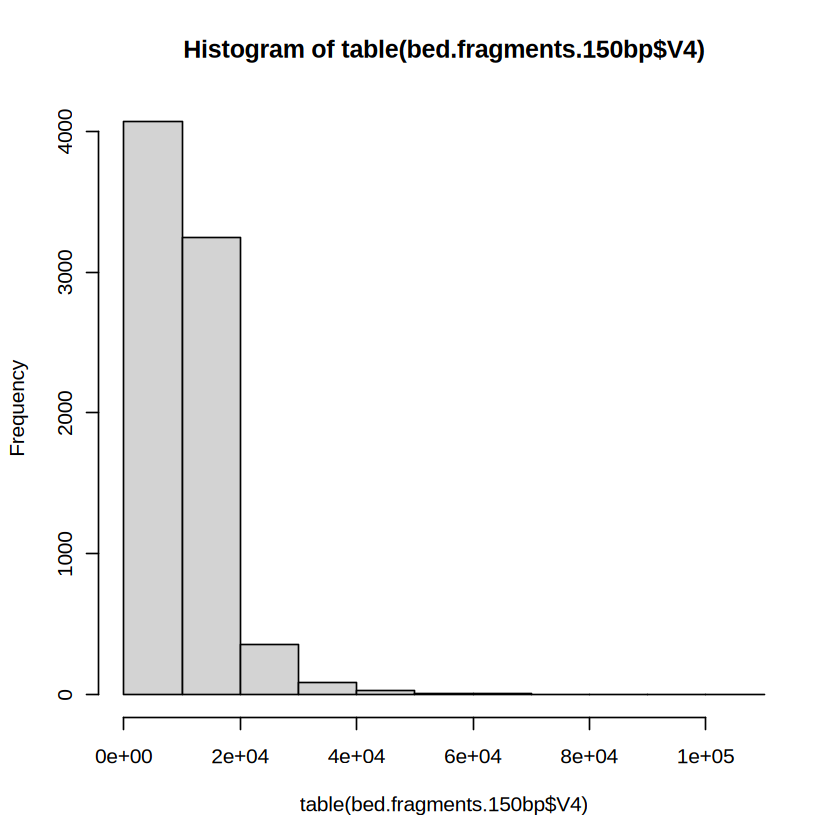

In [7]:
hist(table(bed.fragments.150bp$V4))

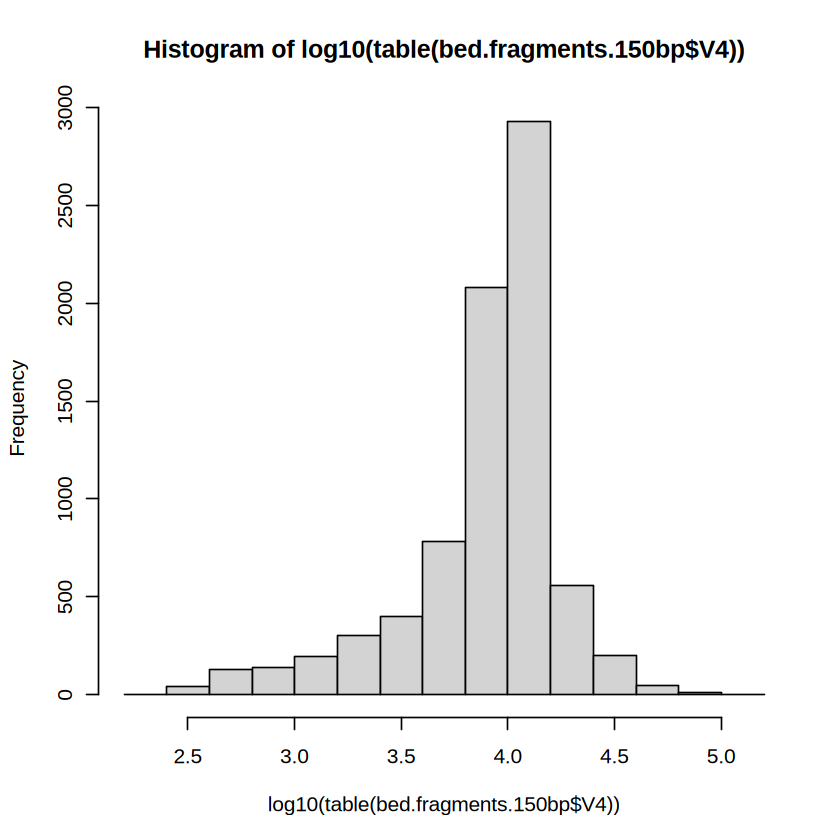

In [8]:
hist(log10(table(bed.fragments.150bp$V4)))

In [9]:
table(log10(table(bed.fragments.150bp$V4)) > 3)


FALSE  TRUE 
  312  7509 

In [13]:
count.frag = data.frame(cell = mcols(bed.fragments.150bp)$V4, count = mcols(bed.fragments.150bp)$V5) %>% 
  group_by(cell) %>%
  summarise(total = sum(count))

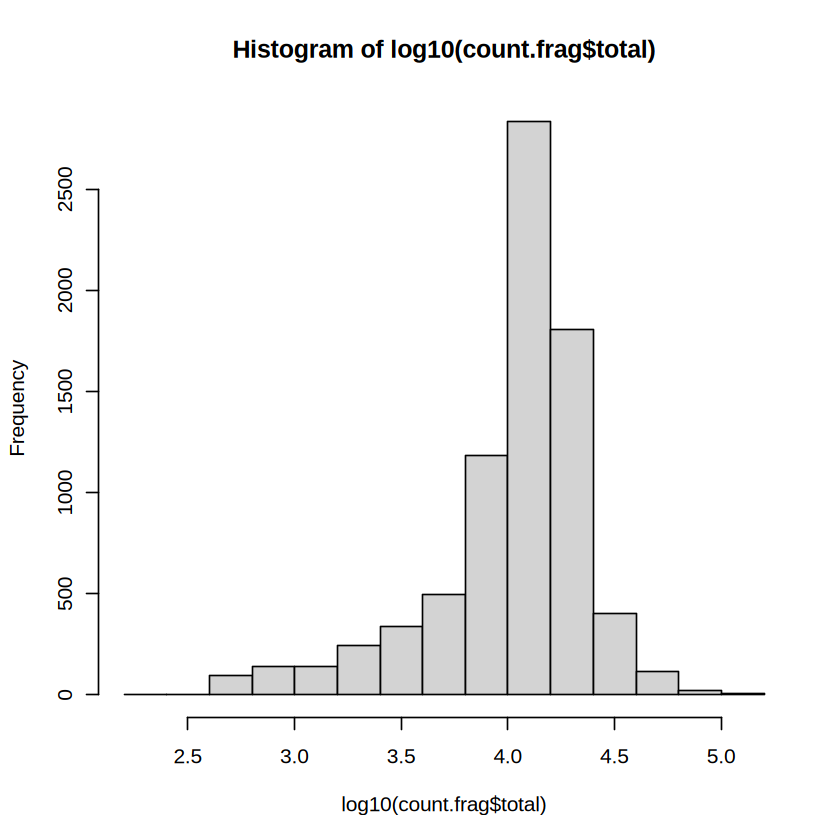

In [15]:
hist(log10(count.frag$total))

In [16]:
table(log10(count.frag$total) > 3)


FALSE  TRUE 
  236  7585 

In [39]:
cells.filter = count.frag$cell[log10(count.frag$total) > 3]

In [41]:
bed.fragments.150bp.filter = bed.fragments.150bp[bed.fragments.150bp$V4 %in% cells.filter]
bed.fragments.150bp.filter

GRanges object with 80023830 ranges and 2 metadata columns:
             seqnames            ranges strand |                     V4
                <Rle>         <IRanges>  <Rle> |            <character>
         [1]     chr1        9985-10132      * | K562_Xu_CGTAGCGGTTTA..
         [2]     chr1        9987-10114      * | K562_Xu_TCATAACCATTG..
         [3]     chr1        9987-10125      * | K562_Xu_GACCGTTCAATT..
         [4]     chr1        9989-10103      * | K562_Xu_GACCTTTGTTAG..
         [5]     chr1        9989-10124      * | K562_Xu_TCCATTGTCCTT..
         ...      ...               ...    ... .                    ...
  [80023826]     chrY 56886505-56886646      * | K562_Xu_CTGAAACTCCGC..
  [80023827]     chrY 56886526-56886665      * | K562_Xu_TGACTTAAGCGA..
  [80023828]     chrY 56886546-56886615      * | K562_Xu_CCAGGAACAGCA..
  [80023829]     chrY 56886938-56887000      * | K562_Xu_TGGACTAGTTGC..
  [80023830]     chrY 56887056-56887202      * | K562_Xu_TGTGGAGCAGTT..
    

In [42]:
80023830/80147971

[1] 0.9984511

In [43]:
obj.seurat.filter = subset(obj.seurat.qc,
                           cells = cells.filter)

In [46]:
dir.create("../../../data/K562_Xu/1.prepare_data/2.filter_150bp_fragment.240531/",recursive = T)

In [47]:
write.table(as.data.frame(bed.fragments.150bp.filter)[,c(1:3,6,7)],
            "../../../data/K562_Xu/1.prepare_data/2.filter_150bp_fragment.240531/atac_fragments.tsv",
            col.names = F,
            row.names = F,
            quote = F,
            sep = "\t")
bgzip("../../../data/K562_Xu/1.prepare_data/2.filter_150bp_fragment.240531/atac_fragments.tsv",
      "../../../data/K562_Xu/1.prepare_data/2.filter_150bp_fragment.240531/atac_fragments.tsv.gz",
     overwrite = T)


indexTabix("../../../data/K562_Xu/1.prepare_data/2.filter_150bp_fragment.240531/atac_fragments.tsv.gz",
           format = "bed")

system("rm -f ../../../data/K562_Xu/1.prepare_data/2.filter_150bp_fragment.240531/atac_fragments.tsv")

[1] "../../../data/K562_Xu/1.prepare_data/2.filter_150bp_fragment.240531/atac_fragments.tsv.gz"

[1] "../../../data/K562_Xu/1.prepare_data/2.filter_150bp_fragment.240531/atac_fragments.tsv.gz.tbi"

In [48]:
write.csv(as.data.frame(obj.seurat.filter@assays$RNA$count),
          "../../../data/K562_Xu/1.prepare_data/2.filter_150bp_fragment.240531/rna_count_matrix.csv.gz",
          quote = F)

Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 3.5 GiB”


In [49]:
saveRDS(obj.seurat.filter,
         "../../../data/K562_Xu/1.prepare_data/2.filter_150bp_fragment.240531/obj.seurat.qc.rds")

In [51]:
count.frag.filter = count.frag[count.frag$cell %in% cells.filter,]

In [52]:
dim(count.frag.filter)

[1] 7585    2

In [53]:
mean(count.frag.filter$total)

[1] 13825.39

In [54]:
median(count.frag.filter$total)

[1] 12993

In [55]:
mean(obj.seurat.filter$gex_umis_count)

[1] 18031.75

In [56]:
median(obj.seurat.filter$gex_umis_count)

[1] 15802

In [57]:
sessionInfo()

R version 4.3.3 (2024-02-29)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Red Hat Enterprise Linux 8.9 (Ootpa)

Matrix products: default
BLAS/LAPACK: /maps/projects/ralab/people/lpm537/software/anaconda3/envs/Notebook_E2G_240505/lib/libopenblasp-r0.3.27.so;  LAPACK version 3.12.0

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

time zone: Europe/Copenhagen
tzcode source: system (glibc)

attached base packages:
[1] stats4    grid      stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] dplyr_1.1.4          Rsamtools_2.18.0     Biostrings_2.70.1   
 [4] XVector_0.42.0       GenomicRanges_1.54.1 GenomeInfoDb_1.38.1 